# Анализ временных рядов
## Михаил Ховричев

# Знакомство с данными

Во всех процедурах проверки гипотез уровень значимости $\alpha$ принимается равным $0.05$.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12, 8)

In [2]:
ts = pd.Series.from_csv('ts.txt', index_col=None)
val_obs = ts[-1:] #221.2744
ts = ts[:-1] # last observation for validation of prediction

In [3]:
ts.head()

0    -8.7750
1    -7.5500
2    -6.3250
3   -22.9932
4   -34.3218
dtype: float64

In [4]:
ts.tail()

194    204.7044
195    219.3616
196    234.5975
197    252.0001
198    235.1367
dtype: float64

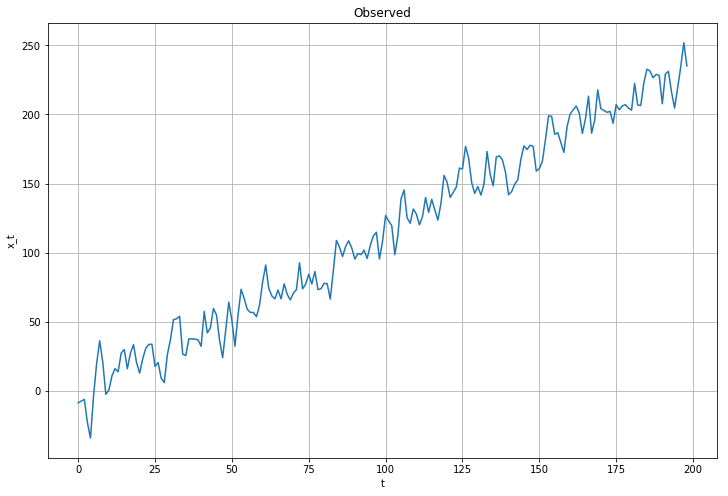

In [178]:
plt.title('Observed')
plt.grid()
plt.plot(ts, label='Observed')
plt.xlabel('t')
plt.ylabel('x_t')

Нужно удалить детерминированные составляющие. Из графика очевидно наличие линейного тренда. Позже будет заметно, что сезонности нет.

# Детрендирование

In [252]:
x = sm.add_constant(ts.index)
tr = sm.OLS(ts, x).fit()
tr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     7278.
Date:                Sun, 26 Mar 2017   Prob (F-statistic):          1.63e-157
Time:                        09:30:13   Log-Likelihood:                -767.96
No. Observations:                 199   AIC:                             1540.
Df Residuals:                     197   BIC:                             1547.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.0983      1.629     -3.744      0.000      -9.311      -2.886
x1             1.2142      0.014     85.313      0.000       1.186       1.242
==============================================================================
Omnibus:                        0.141   Durbin-Watson:                   1.068
Prob(Omnibus):                  0.932   Jarque-Bera (JB):                0.079
Skew:                           0.049   Prob(JB):                        0.961
Kurtosis:                       2.999   Cond. No.                         228.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [253]:
print('Equation of linear trend: f(t) =', tr.params['x1'],'*t +',tr.params['const'])

Equation of linear trend: f(t) = 1.21416978224 *t + -6.09832452261


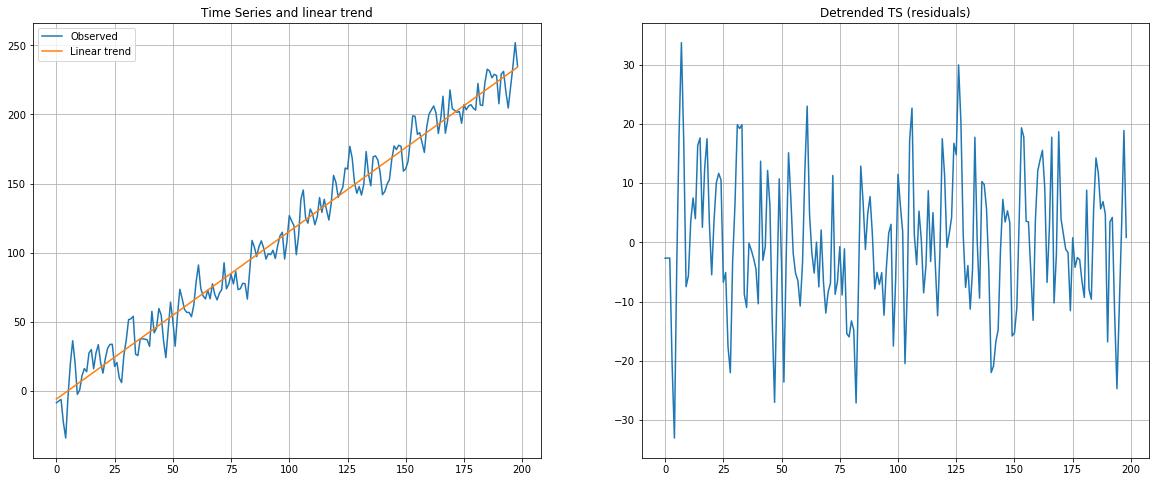

In [254]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
axes[0].set_title('Time Series and linear trend')
axes[0].grid()
axes[0].plot(ts, label='Observed')
axes[0].plot(tr.fittedvalues, label='Linear trend')
axes[0].legend(loc='best')

u = ts - tr.predict() # residuals <=> detrended TS

axes[1].set_title('Detrended TS (residuals)')
axes[1].grid()
axes[1].plot(u)

Теперь отдельно рассмотрим ряд остатков.

Изначальная модель: $x_t = \mu + bt + u_t$<br>
$u_t$ — детрендированный ряд.

# Идентификация модели детрендированного ряда

In [182]:
def acfpacf(res,name):
    nlags=60; z=1.96
    borderline = z/np.sqrt(res.shape[0]) 
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    extraticks=[-borderline, borderline]
    acf = sm.tsa.stattools.acf(res, nlags=nlags)
    pacf = sm.tsa.stattools.pacf(res, nlags=nlags)
    axes[0].set_title('ACF for '+name)
    axes[0].grid()
    axes[0].plot(acf,marker = 'o', linestyle=':', color='magenta')
    axes[0].axhspan(-borderline, borderline, alpha=0.15, color='blue')
    axes[0].set_yticks(list(axes[0].get_yticks()) + extraticks)
    axes[0].set_xlabel('lag')
    axes[1].set_title('PACF for '+name)
    axes[1].grid()
    axes[1].plot(pacf, marker = 'o', linestyle='-.', color='green')
    axes[1].axhspan(-borderline, borderline, alpha=0.15, color='blue')
    axes[1].set_yticks(list(axes[1].get_yticks()) + extraticks)
    axes[1].set_xlabel('lag')
    
    return

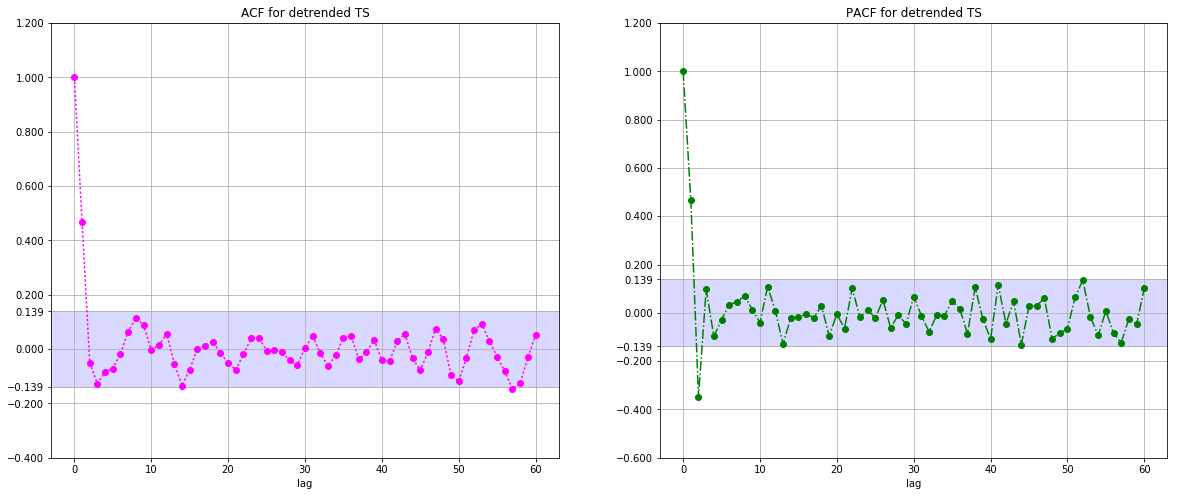

In [183]:
acfpacf(u,'detrended TS')

Некоррелированность $u_t$ можно увидеть из корреллограмм. А именно, начиная с некоторого номера почти все значения выборочной АКФ должны попадать в трубку $[\frac{-1.96}{\sqrt{n}}; +\frac{-1.96}{\sqrt{n}}] = [-0.139; 0.139]$ (допускается редкое несистемное незначительное нарушение границ).  В данном случае значения выборочной АКФ попадют в трубку с номера 3, выборочной ЧАКФ — с номера 4. Раз ряд без тренда не автокоррелирует, значит, сезонности нет и нет смысла её убирать.

## AR(2)

Рассмотрим модель $u_t=\alpha_1 u_{t-1} + \alpha_2 u_{t-2}+\varepsilon_t$

In [266]:
#AR(2)
x = np.column_stack((u[1:ts.shape[0]-1], u[0:ts.shape[0]-2])) # [u_{t-1}, u_{t-2}]
y = u[2:ts.shape[0]] # u_t
y_ar2 = y
ar2 = sm.OLS(y,x).fit() # u_t ~ u_{t-1} u_{t-2}
eps_ar2 = ar2.resid
ar2.summary('u_t', ['u_(t-1)','u_(t-2)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    u_t   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     43.90
Date:                Sun, 26 Mar 2017   Prob (F-statistic):           1.81e-16
Time:                        09:33:28   Log-Likelihood:                -724.57
No. Observations:                 197   AIC:                             1453.
Df Residuals:                     195   BIC:                             1460.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
u_(t-1)        0.6280      0.067      9.330      0.000       0.495       0.761
u_(t-2)       -0.3483      0.068     -5.141      0.000      -0.482      -0.215
==============================================================================
Omnibus:                        2.318   Durbin-Watson:                   1.927
Prob(Omnibus):                  0.314   Jarque-Bera (JB):                2.054
Skew:                          -0.147   Prob(JB):                        0.358
Kurtosis:                       2.595   Cond. No.                         1.66
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Из таблицы сразу же можно получить некоторую информацию о модели. 

### Проверка остатков:

Нужно проверить ряд $\varepsilon_t$ на три свойства:

1. Некоррелированность
2. Гауссовость
3. Гомоскедастичность

**Некоррелированность**

Используем сразу несколько инструментов для проверки некоррелированности. Для начала построим выборочные АКФ и ЧАКФ для ряда $\varepsilon_{t}$.

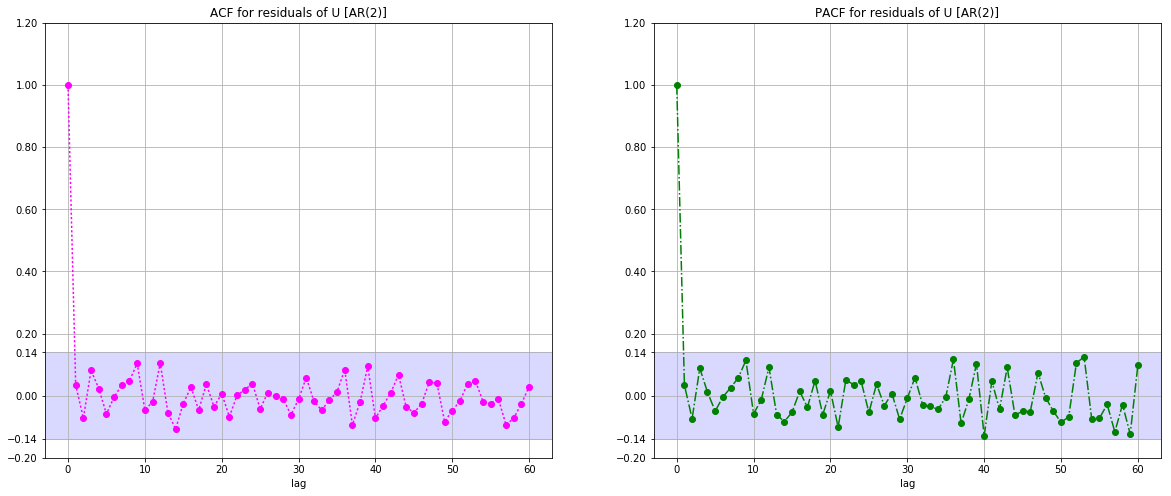

In [255]:
acfpacf(eps_ar2, 'residuals of U [AR(2)]')

Некоррелированность остатков можно увидеть из корреллограмм. А именно, начиная с некоторого номера почти все значения АКФ должны попадать в трубку $[\frac{-1.96}{\sqrt{n}}; +\frac{-1.96}{\sqrt{n}}] = [-0.14; 0.14]$.  В данном случае это происходит практически сразу же, что говорит о некоррелированности $\varepsilon_t$

Проверим гипотезу с помощью критерия Дарбина-Уотсона. Формальная запись:

$H_0: \forall i={1,\dots,n} \quad \rho(\varepsilon_i, \varepsilon_{i-1}) = 0$<br>
$H_A: \exists i: \rho(\varepsilon_i, \varepsilon_{i-1}) ≠ 0$

$p=2, \quad n = |U|-p$

Значение статистики, полученное из таблицы: $DW = 1.927$.<br>
Статистики распределения Дарбина-Уотсона при количестве регрессоров $m=2$:

$d_L =1.748; d_U = 1.789$, причём:
* $[0; d_L], [4-d_L;4]$ — критические области
* $[d_U; 4-d_U]$ — доверительная область
* $[d_L;d_U], [4-d_U; 4-d_L]$ — области неопределённости. 

$DW$ попадает в доверительную область, а значит, принимаем гипотезу о некоррелированности остатков.

** Гауссовость **

Критерий Харке-Бера.

<cite>$p$-значение — вероятность ошибиться, отвергнув нулевую гипотезу. Если p(t) меньше заданного уровня значимости, то нулевая гипотеза отвергается в пользу альтернативной. В противном случае она не отвергается.</cite>

Проверяем гипотезу о нормальности остатков, выраженную через коэффициенты ассиметрии (**S**kew) и эксцесса (**K**).

$H_0: S=0, K=3$<br>
$H_A: S≠0, K≠3$


$p$-$value = 0.358 > \alpha = 0.05$, а значит, нет оснований для отклонения нулевой гипотезы.

$JB_{|H_0} \sim \chi^2(2)$.  $\chi_{\alpha}^2=6$

$JB = 2.054 < 6$, попали в доверительную область. Обе процедуры проверки гипотезы подтверждают гауссовость остатков.


**Гомоскедастичность**

Воспользуемся критерием Голдфельда-Куандта в предположении, что остатки имеют нормальное распределение. 

$H_0: \sigma_1 = \dots = \sigma_n = \sigma $<br>
$H_A: {\exists k: \sigma_i = \sigma_0u_{t-k}^{i}}$


$p=2, \quad n = |U|-p$<br>
$i={1,\dots,n},\quad k={1, \dots, p}$.

Выбрасываем $d$ средних наблюдений. Важно, чтобы выполнялось условие $\frac{n-d}{2} > m$. Пусть $d=71$.

$T_{|H_0}  \sim  F(\frac{n-d}{2}-m;\  \frac{n-d}{2}-m); \quad \frac{n-d}{2}-m  = 60$


$F_{0.95}(60;60) = 1.53$, критическая область справа.

In [167]:
T_ar2, pv_ar2 = sm.stats.diagnostic.het_goldfeldquandt(eps_ar2,ar2.model.exog,split=71)[:-1]
print('T =',T_ar2)
print('p-value =', pv_ar2)

T = 0.920855971721
p-value = 0.642584814056


Значение статистики попало в доверительную область.<br>
$p$-$value > \alpha$, нет оснований для отклонения нулевой гипотезы.

Делаем вывод, что ряд $\varepsilon_t$ действительно является гауссовским белым шумом.

### Проверка значимости коэффициентов

Проверим гипотезу о значимости коэффициентов детрендированного ряда, в данном случае $\hat{\alpha} = \alpha_{k} \quad \forall k=1, \dots, p$

$H_0: \hat{\alpha}=0$<br>
$H_A: \hat{\alpha}≠0$

Статистика критерия Стьюдента $t = \frac{\hat{\alpha}}{\sqrt{\hat{D}\hat{\alpha}}} |_{H_0} \sim t(n-2)$

Из таблицы видим, что $t_{\alpha_1} = 9.33, \quad t_{\alpha_2} = -5.141$

Критические точки: $t_{0.025; 195} = -1.973 \quad t_{0.975; 195} = 1.973$.

Статистики для обоих коэффициентов попали в критическую область, значит, все коэффициенты значимы.


### Проверка наличия единичного корня

$u_t=\alpha_1 u_{t-1} + \alpha_2 u_{t-2}+\varepsilon_t$<br>
$u_t = (\alpha_1 +\alpha_2 ) u_{t-1} - \alpha_2\Delta u_{t-1} = \gamma  u_{t-1} - \alpha_2\Delta u_{t-1}$
    
$H_0: \gamma = 1$<br>
$H_A: \gamma<1$

Статистика расширенного критерия Дики-Фуллера $t = \frac{\hat{\gamma}}{\sqrt{\hat{D}\hat{\gamma}}} |_{H_0} \sim DF_0(n)$, так как ряд уже детрендировали.

In [256]:
print('t=', sm.tsa.stattools.adfuller(y)[0])
print('DF0 critical (5%):', sm.tsa.stattools.adfuller(y)[4]['5%'])

t= -7.84988315377
DF0 critical (5%): -2.87655643617


Попали в критическую область (слева от $DF_0$), не можем принять гипотезу о DS-природе ряда.

### Информационные критерии
Из таблицы:
$AIC = 1453, \quad BIC =1460$

## AR(3)
$u_t=\alpha_1 u_{t-1} + \alpha_2 u_{t-2} + \alpha_3 u_{t-3} +\varepsilon_t$

Будем использовать те же критерии и вышеописанные гипотезы (при $p=3$)

In [257]:
x = np.column_stack((u[2:ts.shape[0]-1], u[1:ts.shape[0]-2], u[0:ts.shape[0]-3])) # [u_{t-1}, u_{t-2} u_{t-3}]
y = u[3:ts.shape[0]] # u_t
ar3 = sm.OLS(y,x).fit() # u_t ~ u_{t-1} u_{t-2} u_{t-3}
eps_ar3 = ar3.resid
ar3.summary('u_t', ['u_(t-1)','u_(t-2)', 'u_(t-3)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    u_t   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     29.87
Date:                Sun, 26 Mar 2017   Prob (F-statistic):           6.61e-16
Time:                        09:31:41   Log-Likelihood:                -720.42
No. Observations:                 196   AIC:                             1447.
Df Residuals:                     193   BIC:                             1457.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
u_(t-1)        0.6621      0.072      9.217      0.000       0.520       0.804
u_(t-2)       -0.4111      0.082     -5.025      0.000      -0.573      -0.250
u_(t-3)        0.0989      0.072      1.367      0.173      -0.044       0.242
==============================================================================
Omnibus:                        1.660   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.436   Jarque-Bera (JB):                1.590
Skew:                          -0.129   Prob(JB):                        0.451
Kurtosis:                       2.642   Cond. No.                         2.30
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Проверка остатков:

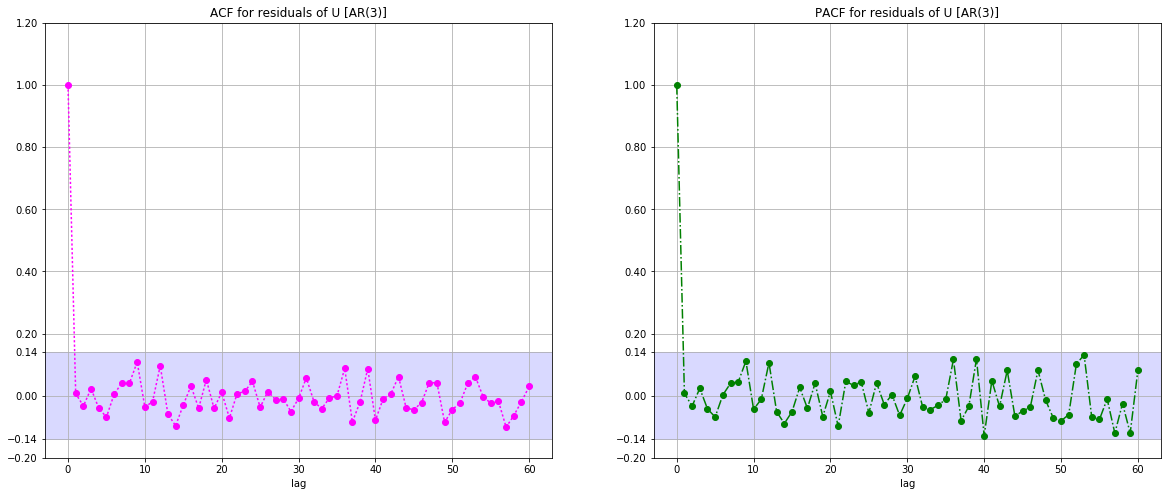

In [258]:
acfpacf(eps_ar3, 'residuals of U [AR(3)]')

**Некоррелированность**


$m=3; p=3; n=196$ <br>
$DW=1.927$ <br>
$d_L = 1.738,\quad d_U = 1.799$

Попадаем в доверительную область. Остатки не корреллированы.

**Гауссовость**

$JB = 1.59<6 \quad p$-$value = 0.451 > \alpha$. 
Попадаем в доверительную область, $p$-значение больше уровня значимости. Остатки распределены нормально.

**Гомоскедастичность**

$d=70$<br>
$F_{0.95}(60;60) = 1.53$, критическая область справа.

In [206]:
T_ar3, pv_ar3 = sm.stats.diagnostic.het_goldfeldquandt(eps_ar3,ar3.model.exog,split=70)[:-1]
print('T =',T_ar3)
print('p-value =', pv_ar3)

T = 0.886807717189
p-value = 0.703100772703


Значение статистики попало в доверительную область.<br>
$p$-$value > \alpha$, нет оснований для отклонения нулевой гипотезы.

Делаем вывод, что ряд $\varepsilon_t$ действительно является гауссовским белым шумом.

### Проверка значимости коэффициентов

Из таблицы видим, что:<br>
$t_{\alpha_1} = 9.217, \quad t_{\alpha_2} = -5.025, \quad t_{\alpha_3}=1.367$

Критические точки: $t_{0.025; 194} = -1.973 \quad t_{0.975; 194} = 1.973$.

Статистики для первых двух коэффициентов попали в критическую область, значит, они значимы. Статистика третьего коэффициента попала в доверительную область, значит, принимаем гипотезу о его незначимости.


### Проверка наличия единичного корня

In [259]:
print('t=', sm.tsa.stattools.adfuller(y)[0])
print('DF0 critical (5%):', sm.tsa.stattools.adfuller(y)[4]['5%'])

t= -10.6861880023
DF0 critical (5%): -2.87655643617


Попали в критическую область (слева от $DF_0$), не можем принять гипотезу о DS-природе ряда.

### Информационные критерии
Из таблицы:
$AIC = 1447, \quad BIC =1457$

## AR(4)
$u_t=\alpha_1 u_{t-1} + \alpha_2 u_{t-2} + \alpha_3 u_{t-3} +\alpha_4 u_{t-4} +\varepsilon_t$

Будем использовать те же критерии и вышеописанные гипотезы (при $p=4$)

In [260]:
x = np.column_stack((u[3:ts.shape[0]-1], u[2:ts.shape[0]-2], u[1:ts.shape[0]-3], u[0:ts.shape[0]-4]))
y = u[4:ts.shape[0]] # u_t
ar4 = sm.OLS(y,x).fit() # u_t ~ u_{t-1} u_{t-2} u_{t-3} u_{t-4}
eps_ar4 = ar4.resid
ar4.summary('u_t', ['u_(t-1)','u_(t-2)', 'u_(t-3)', 'u_(t-4)'])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    u_t   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.313
Method:                 Least Squares   F-statistic:                     23.18
Date:                Sun, 26 Mar 2017   Prob (F-statistic):           1.24e-15
Time:                        09:32:02   Log-Likelihood:                -714.26
No. Observations:                 195   AIC:                             1437.
Df Residuals:                     191   BIC:                             1450.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
u_(t-1)        0.6688      0.071      9.362      0.000       0.528       0.810
u_(t-2)       -0.4489      0.086     -5.221      0.000      -0.618      -0.279
u_(t-3)        0.1594      0.086      1.850      0.066      -0.011       0.329
u_(t-4)       -0.0942      0.072     -1.308      0.193      -0.236       0.048
==============================================================================
Omnibus:                        1.249   Durbin-Watson:                   2.019
Prob(Omnibus):                  0.536   Jarque-Bera (JB):                1.349
Skew:                          -0.162   Prob(JB):                        0.509
Kurtosis:                       2.752   Cond. No.                         2.71
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Проверка остатков:

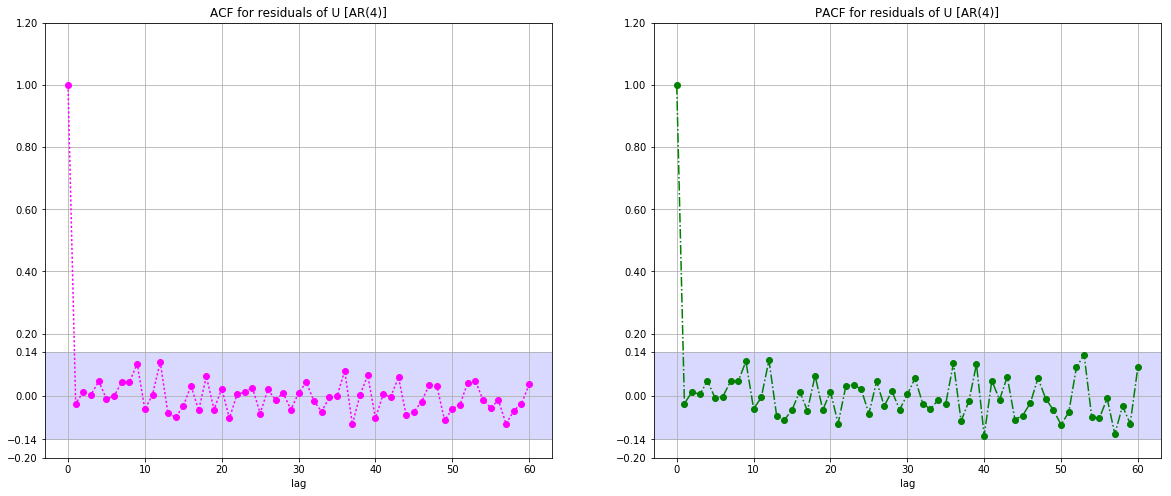

In [261]:
acfpacf(eps_ar4, 'residuals of U [AR(4)]')

**Некоррелированность**


$m=4; p=4; n=195$ <br>
$DW=1.927$ <br>
$d_L = 1.728,\quad d_U = 1.81$

Попадаем в доверительную область. Остатки не корреллированы.

**Гауссовость**

$JB = 1.349<6 \quad p$-$value = 0.509 > \alpha$. 
Попадаем в доверительную область, $p$-значение больше уровня значимости. Остатки распределены нормально.

**Гомоскедастичность**

$d=67$<br>
$F_{0.95}(60;60) = 1.53$, критическая область справа.

In [262]:
T_ar4, pv_ar4 = sm.stats.diagnostic.het_goldfeldquandt(eps_ar4,ar4.model.exog,split=67)[:-1]
print('T =',T_ar4)
print('p-value =', pv_ar4)

T = 0.922800254946
p-value = 0.633332308917


Значение статистики попало в доверительную область.<br>
$p$-$value > \alpha$, нет оснований для отклонения нулевой гипотезы.

Делаем вывод, что ряд $\varepsilon_t$ действительно является гауссовским белым шумом.

### Проверка значимости коэффициентов

Из таблицы видим, что:<br>
$t_{\alpha_1} = 9.362, \quad t_{\alpha_2} = -5.221, \quad t_{\alpha_3}=1.850, \quad t_{\alpha_4}= -1.308$

Критические точки: $t_{0.025; 194} = -1.973 \quad t_{0.975; 194} = 1.973$.

Статистики для первых двух коэффициентов попали в критическую область, значит, они значимы. 

Статистики третьего и четвёртого коэффициентов попали в доверительную область, значит, принимаем гипотезу об их незначимости.


### Проверка наличия единичного корня

In [263]:
print('t=', sm.tsa.stattools.adfuller(y)[0])
print('DF0 critical (5%):', sm.tsa.stattools.adfuller(y)[4]['5%'])

t= -10.2873924808
DF0 critical (5%): -2.87663488473


Попали в критическую область (слева от $DF_0$), не можем принять гипотезу о DS-природе ряда.

### Информационные критерии

Из таблицы:
$AIC = 1437, \quad BIC =1450$

# Выбор лучшей модели

Так как в моделях AR(3), AR(4) принималась гипотеза о незначимости регрессоров $u_{t-3}, u_{t-4}$, то основной моделью остаётся AR(2), хоть и значения информационных критериев для AR(3), AR(4) меньше.

Таким образом, 

$x_t = \hat{\mu} + \hat{b} t+ \hat{\alpha}_1(x_{t-1} - \hat{\mu} - \hat{b}(t-1)) + \hat{\alpha}_2(x_{t-2} - \hat{\mu} - \hat{b}(t-2))$

$x_t = \mu + bt + \alpha_1 u_{t-1} + \alpha_2 u_{t-2} + \varepsilon_t$, где $\varepsilon_t$ — гауссовский белый шум.

Итого:

$x_t = -4.48 + 0.87t + 0.63 x_{t-1} -0.35 x_{t-2} $

# Прогноз

Попробуем предсказать последнее значение ряда с помощью этой модели и сравним его с истинным.

In [264]:
pred = -6.1+ 1.21*(198+1) + 0.6280*(ts[198] +6.1 -1.21*198) - 0.3483*(ts[197]+6.1-1.21*(198-1))

In [265]:
print('Predicted value: ', pred)
print('True value:', val_obs.values[0])
print('Absolute error:', abs(pred-val_obs.values[0]))

Predicted value:  228.85841377
True value: 221.2744
Absolute error: 7.58401377


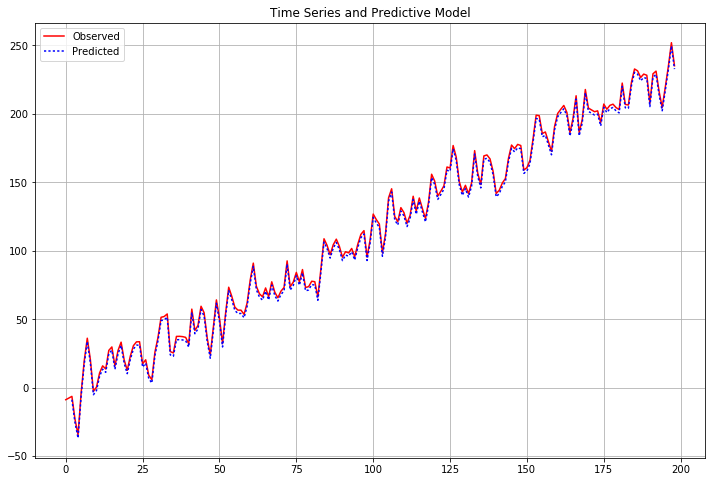

In [268]:
plt.title('Time Series and Predictive Model')
plt.grid()
plt.plot(ts, color='red', label='Observed')
plt.plot(y_ar2+tr.predict()[:-2], linestyle=':', color='blue', label='Predicted')
plt.legend(loc='best')

Как видим, модель подогналась довольно точно.